In [10]:
from pyicecube10.analysis import AnalyzeCircle, energybins
from astropy.io import ascii
import emcee
from numpy.random import default_rng
rng = default_rng()
import os
from matplotlib import pyplot as plt
import numpy as np
from gammapy.stats import wstat
import arviz
from scipy.stats import poisson
from matplotlib.colors import LogNorm
from gammapy.stats import WStatCountsStatistic
import multiprocessing
import itertools
from astropy.coordinates import SkyCoord
import pyicecube10

In [11]:
anal = AnalyzeCircle(40.67, -0.01, 1, 1, years=pyicecube10.years)

In [12]:
tpb = anal.total_per_bin()
bpb = anal.background_per_bin()

In [13]:
cumtotal = anal.cumulative_total()
cumback = anal.cumulative_background()

In [14]:
cumtotal-cumback

array([ 4.06760563e+01,  4.06760563e+01,  4.06760563e+01,  4.06760563e+01,
        4.06760563e+01,  4.06760563e+01,  4.06760563e+01,  4.06760563e+01,
        4.06760563e+01,  4.06760563e+01,  4.06901408e+01,  4.07323944e+01,
        4.09859155e+01,  3.86901408e+01,  3.65774648e+01,  1.60422535e+01,
        9.46478873e+00,  1.00281690e+01,  2.22535211e+00,  4.42253521e+00,
        2.66197183e+00,  1.85915493e+00,  5.21126761e-01,  7.88732394e-01,
       -1.26760563e-01, -8.45070423e-02, -5.63380282e-02, -1.40845070e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

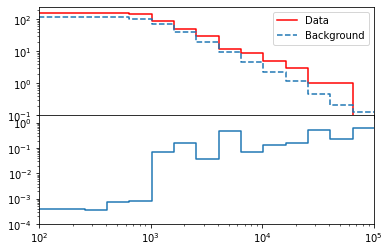

In [19]:
# Cumulative signal, background; significance in terms of p-value
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

axs[0].step(energybins['Emu'], cumtotal, where='mid', ls='-', c='r', label='Data')
axs[0].step(energybins['Emu'], cumback, where='mid', ls='--', label='Background')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(0.1)
axs[0].set_xlim(1e2, 1e5)
axs[0].legend()

axs[1].step(energybins['Emu'], WStatCountsStatistic(cumtotal, 71 * cumback, 1/71, 0).p_value, where='mid')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4, 2)
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [20]:
# Max significance with energy cut of 
energybins['Emu_min'][np.argmin(WStatCountsStatistic(cumtotal, 71 * cumback, 1/71, 0).p_value)]

251.18864315095823

Fit spectra using MCMC

In [21]:
def powerlaw(A, gamma):
    return A * 1e-11 * 1e-3 * (energybins['Enu'] / 1e3)**(-gamma)

In [31]:
def log_prior(args):
    A, gamma = args
    if 0<A<10 and 2<gamma<6:
        return 0.0
    return -np.inf

def log_prob(args):
    lp = log_prior(args) 
    if not np.isfinite(lp):
        return -np.inf
    return lp - 0.5 * sum(wstat(tpb, 71 * bpb, 1/71, anal.expected_counts(powerlaw, *args)))

In [32]:
pos = np.array([1., 2.2]) + rng.standard_normal(size=(32, 2))
nwalkers, ndim = pos.shape


from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler.run_mcmc(pos, 3000, progress=True);

del(os.environ["OMP_NUM_THREADS"])

  0%|                                                                                                                                    | 0/3000 [00:00<?, ?it/s]/home/dsavchenko/anaconda3/envs/gammapy/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:21<00:00, 142.54it/s]


In [33]:
sampler.get_autocorr_time()

array([37.51986346, 44.91244037])

In [34]:
ardata = arviz.from_emcee(sampler=sampler, var_names=('norm', 'gamma'))
ardata = ardata.sel(draw=slice(200, None, 5))

array([<AxesSubplot:title={'center':'norm'}>,
       <AxesSubplot:title={'center':'gamma'}>], dtype=object)

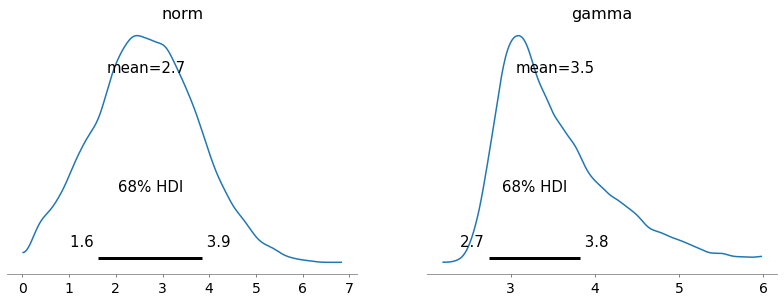

In [35]:
arviz.plot_posterior(ardata, hdi_prob=0.68)

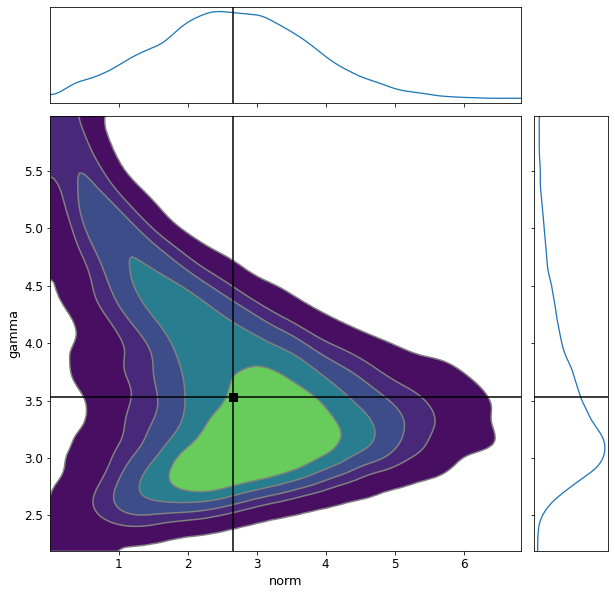

In [36]:
axs = arviz.plot_pair(ardata, kind=('kde'), marginals=True, point_estimate='mean', kde_kwargs={'hdi_probs': (.393, .682, .865, .952, .997)}, figsize = (10, 10), textsize=12)

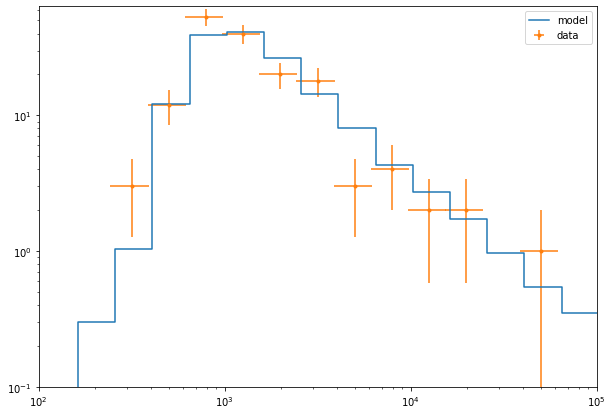

In [38]:
Emu, Emu_min, Emu_max = energybins['Emu'], energybins['Emu_min'], energybins['Emu_max']
plt.figure(figsize=(10,7))
#plt.step(Enu, total_nu_counts, label=r'$\nu$', where='mid')
plt.step(Emu, anal.expected_counts(powerlaw, 1.1, 2.5) + bpb, where='mid', label = 'model')
plt.errorbar(Emu, tpb, xerr=(Emu_max-Emu_min)/2, yerr=np.sqrt(tpb), fmt='.', label = 'data')
plt.xlim(1e2, 1e5)
plt.ylim(0.1)
plt.yscale('log')
plt.xscale('log')
plt.legend()